# a brief tutorial on using `lstbin.py` of `hera_cal`

Jan. 2018

Nick Kern

---

In this brief tutorial, we show you how to use the `lstbin.py` module of `hera_cal` on example HERA data. We will be using data from three nights of raw HERA-47 data, working only on a 7-element subset of the data. Each night contains three files worth of data, which amounts to 180 integrations per night (or 32.1 minutes per night).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
from hera_cal.datacontainer import DataContainer
import aipy
import operator
from memory_profiler import memory_usage as memuse

In [2]:
# load the data
night1 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458042.4*.xx.HH.uvA")))
night2 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458043.4*.xx.HH.uvA")))
night3 = sorted(glob.glob(os.path.join(DATA_PATH, "zen.2458044.4*.xx.HH.uvA")))

uvd1 = UVData()
uvd1.read_miriad(night1)

uvd2 = UVData()
uvd2.read_miriad(night2)

uvd3 = UVData()
uvd3.read_miriad(night3)

# load data and meta data. LST arrays are the lst1, lst2, lst3 variables
data1, wgts1, ap1, a1, f1, t1, lst1, p1 = hc.abscal.UVData2AbsCalDict(uvd1, return_meta=True, return_wgts=True)
data2, wgts2, ap2, a2, f2, t2, lst2, p2 = hc.abscal.UVData2AbsCalDict(uvd2, return_meta=True, return_wgts=True)
data3, wgts3, ap3, a3, f3, t3, lst3, p3 = hc.abscal.UVData2AbsCalDict(uvd3, return_meta=True, return_wgts=True)

In [3]:
# form data list
data_list = [data1, data2, data3]
lst_list = [lst1, lst2, lst3]

# get integration duration in radians
delta_lst = np.median(np.diff(lst1))

# form lst grid starting at 0 radians and going until 2*pi radians
lst_grid = np.arange(0, 2*np.pi, delta_lst)

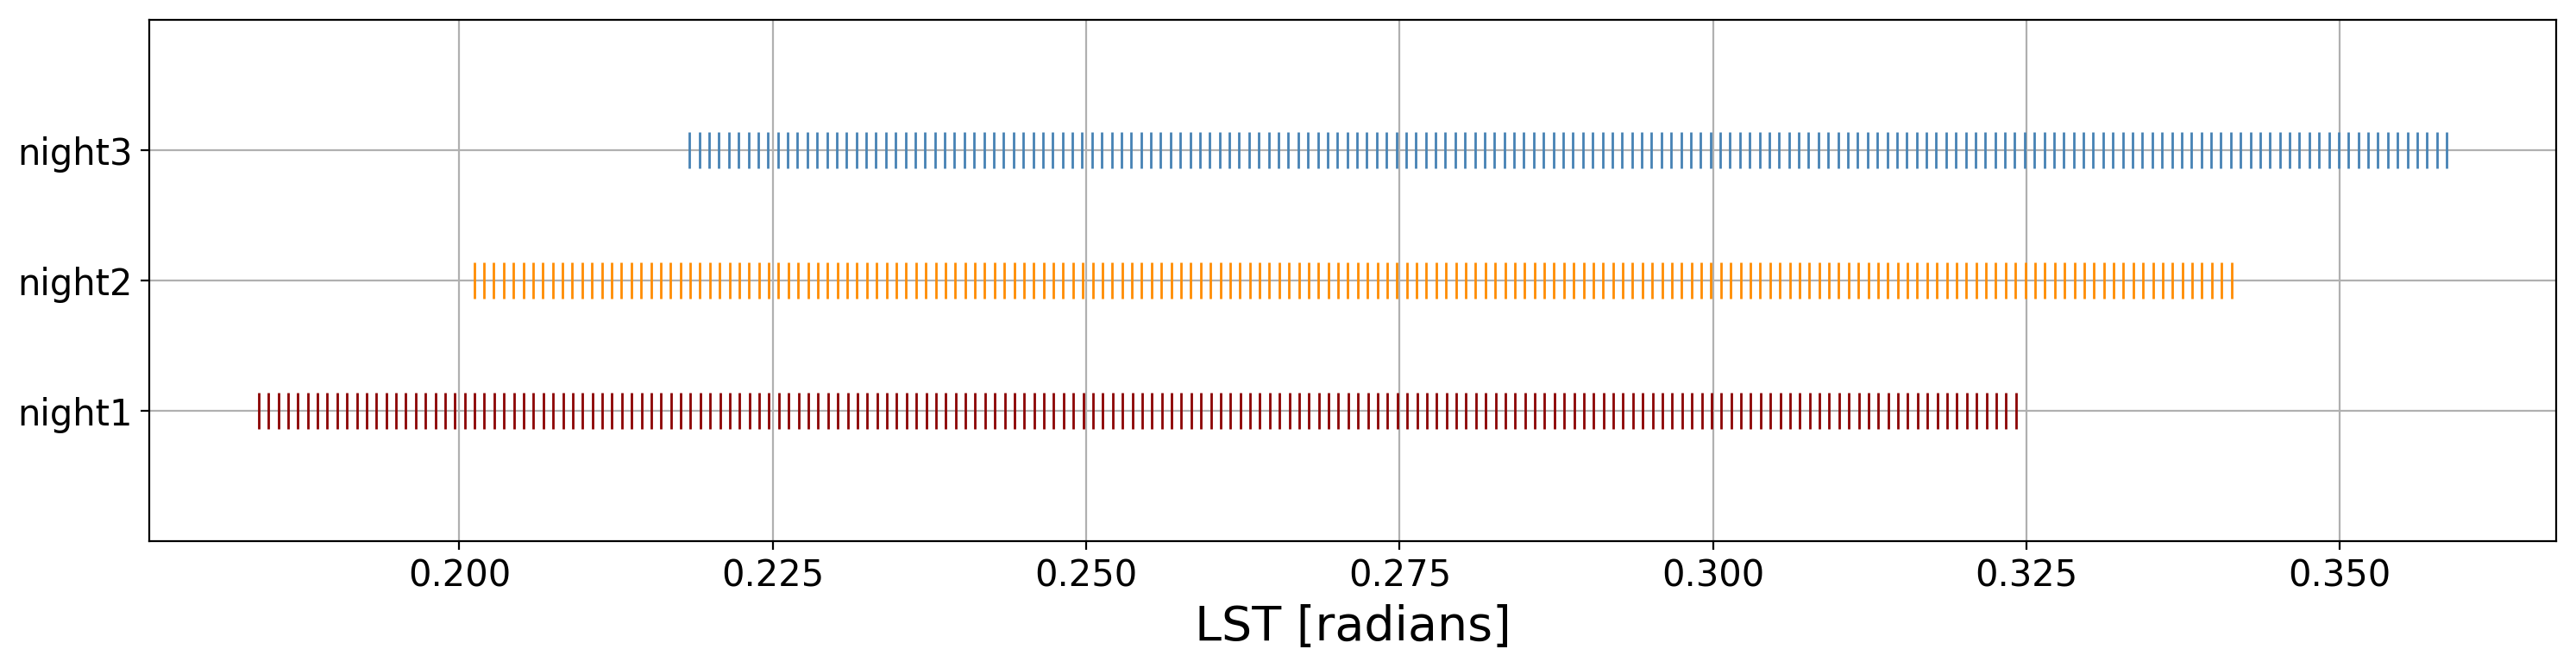

In [4]:
# plot the data's native LST integrations
fig, ax = plt.subplots(1, 1, figsize=(18, 4), dpi=200)
ax.grid()
p1, = ax.plot(lst1, np.ones_like(lst1)*0, color='darkred', ms=15, marker='|', ls='')
p2, = ax.plot(lst2, np.ones_like(lst2)*1, color='darkorange', ms=15, marker='|', ls='')
p3, = ax.plot(lst3, np.ones_like(lst3)*2, color='steelblue', ms=15, marker='|', ls='')
ax.set_ylim(-1, 3)
_ = [tl.set_size(15) for tl in ax.xaxis.get_ticklabels()]
ax.yaxis.set_ticks([0,1,2])
ax.yaxis.set_ticklabels(['night1', 'night2', 'night3'])
_ = [tl.set_size(15) for tl in ax.yaxis.get_ticklabels()]
ax.set_xlabel("LST [radians]", fontsize=20)

We can see from the figure above that the 32 minutes of data from each night do not align perfercly in LST. We see a drift in the LST duration for the data from night-to-night, corresponding to 4 minutes. Also more subtle is the fact that the integrations themselves do perfectly align across nights, even in the overlapping LST range.

## bin data with no LST align

In the steps below, we will form a uniform LST grid and average the three nights of data that fall in each LST bin. We won't take into account the fact that the LST gridding of each night is 1) not aligned between nights and 2) not perfectly aligned with the LST bin itself.

In [9]:
# LST bin!
data_avg, wgts_avg, data_std, lst_bins, data_num = hc.lstbin.lst_bin(data_list, lst_list, lst_grid=lst_grid,
                                                                     lst_init=0, return_no_avg=False)

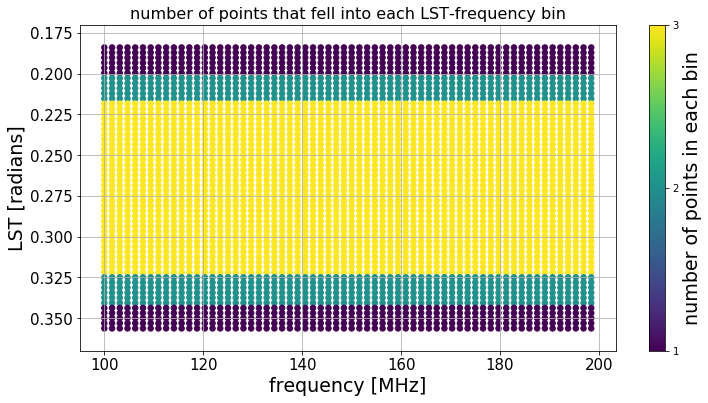

In [10]:
# plot the number of points that fell into each LST bin
key = data_num.keys()[0]
X, Y = np.meshgrid(np.linspace(100, 200, 64, endpoint=False), lst_bins[::4])
X = X.ravel()
Y = Y.ravel()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.grid()
cax = ax.scatter(X, Y, c=data_num[key][::4, :].ravel(), s=30, cmap='viridis')
cbar = fig.colorbar(cax)
cbar.set_ticks([1,2,3])
cbar.set_label('number of points in each bin', fontsize=19)
ax.set_xlabel('frequency [MHz]', fontsize=19)
ax.set_ylabel('LST [radians]', fontsize=19)
ax.set_ylim(0.37, 0.17)
_ = [tl.set_size(15) for tl in ax.get_xticklabels()]
_ = [tl.set_size(15) for tl in ax.get_yticklabels()]
ax.set_title("number of points that fell into each LST-frequency bin", fontsize=16)

Above we show the number of points that fell into each LST-frequency bin. This matches what we would have predicted given the previous figure, and the fact that we made an LST grid with the same time integration length as the data originally had. Below, we plot waterfalls from a 14.6 meter East-West baseline before and after LST binning, where we can see a slight reduction in noise by-eye after LST-binning. Keep in mind that the data in night1 on the left extends to only 160 integrations, while the plot on the right extends all the way to 224 integrations.

divide by zero encountered in log10


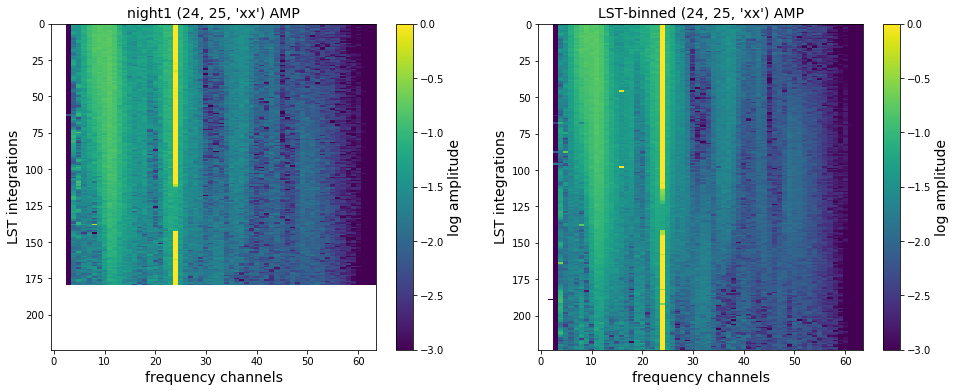

In [11]:
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
plt.sca(ax)
uvt.plot.waterfall(data1[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
uvt.plot.waterfall(data_avg[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

# bin data with LST align

Now we would like to physically interpolate each of the nightly data across time so as to align each night directly with the pre-defined LST grid. The only difference is that before passing the data through `lst_bin`, we will call the `lst_align` function.

In [12]:
# interpolate each data dict onto lst_grid, must set bounds_error = False to not raise an out-of-bounds error
data1_interp, interp_wgts1, interp_lsts1 = hc.lstbin.lst_align(data1, lst1, lst_grid=lst_grid, kind='cubic',
                                                                fill_value=None, lst_init=0, bounds_error=False, 
                                                               smooth_and_slide=False, flag_extrapolate=False)
data2_interp, interp_wgts2, interp_lsts2 = hc.lstbin.lst_align(data2, lst2, lst_grid=lst_grid, kind='cubic',
                                                                fill_value=None, lst_init=0, bounds_error=False, 
                                                               smooth_and_slide=False, flag_extrapolate=False)
data3_interp, interp_wgts3, interp_lsts3 = hc.lstbin.lst_align(data3, lst3, lst_grid=lst_grid, kind='cubic',
                                                                fill_value=None, lst_init=0, bounds_error=False, 
                                                               smooth_and_slide=False, flag_extrapolate=False)

data_list = [data1_interp, data2_interp, data3_interp]
lst_list = [interp_lsts1, interp_lsts2, interp_lsts3]

In [13]:
# LST bin!
data_avg, data_wgts, data_std, lst_bins, data_num = hc.lstbin.lst_bin(data_list, lst_list, lst_grid=lst_grid,
                                                                      lst_init=0)

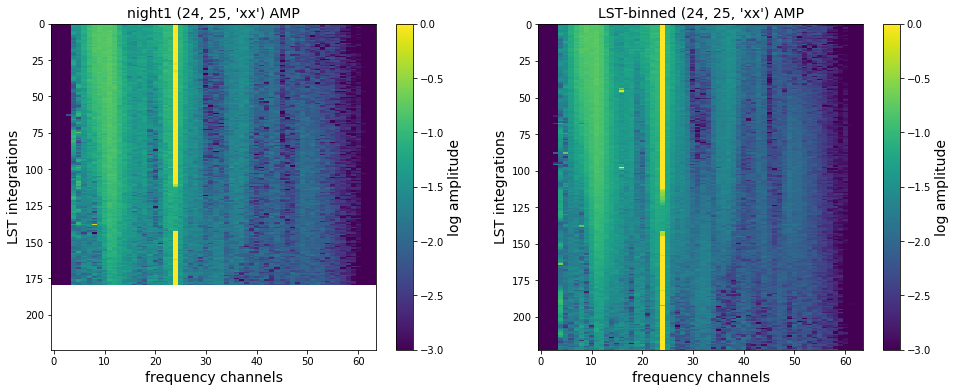

In [14]:
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
plt.sca(ax)
uvt.plot.waterfall(data1_interp[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
uvt.plot.waterfall(data_avg[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

No significant difference can be found by eye, however, further work needs to be done to see if this makes a difference in the delay spectra of the visibility data at high delay.

# bin data with sigma clipping

In this example, we will run a simple 1-iteration sigma clipping algorithm that will reject all points in each LST bin that lie outside of some sigma threshold. For this particular case, we will use a larger LST bin width to accumulate more points per LST bin. For the example, we choose to not LST align, although we could do this as well if we wanted. We will also choose a minimum number of points per LST-bin threshold in order to perform sigma clipping at 5 points. In other words, if an LST-bin contains 4 or less points, we won't perform sigma clipping.

In [5]:
# form lst grid starting at 0 radians and going until 2*pi radians
lst_grid2 = np.arange(0, 2*np.pi, delta_lst*3)

In [14]:
# LST bin, with 5 sigma rejection tolerance
data_avg, wgts_avg, data_std, lst_bins, data_num = hc.lstbin.lst_bin(data_list, lst_list, lst_grid=lst_grid2,
                                                                     lst_init=0, sig_clip=True, sigma=5, min_N=5)

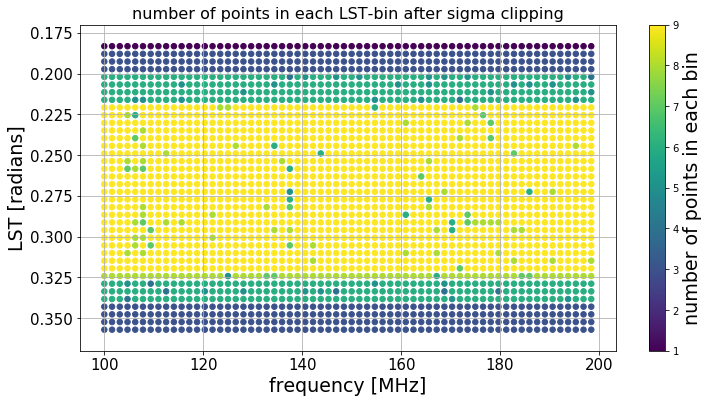

In [15]:
# plot the number of points that fell into each LST bin
key = data_num.keys()[0]
X, Y = np.meshgrid(np.linspace(100, 200, 64, endpoint=False), lst_bins[::2])
X = X.ravel()
Y = Y.ravel()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.grid()
cax = ax.scatter(X, Y, c=data_num[key][::2, :].ravel(), s=30, cmap='viridis')
cbar = fig.colorbar(cax)
cbar.set_ticks(np.arange(1, 11))
cbar.set_label('number of points in each bin', fontsize=19)
ax.set_xlabel('frequency [MHz]', fontsize=19)
ax.set_ylabel('LST [radians]', fontsize=19)
ax.set_ylim(0.37, 0.17)
_ = [tl.set_size(15) for tl in ax.get_xticklabels()]
_ = [tl.set_size(15) for tl in ax.get_yticklabels()]
ax.set_title("number of points in each LST-bin after sigma clipping", fontsize=16)

divide by zero encountered in log10


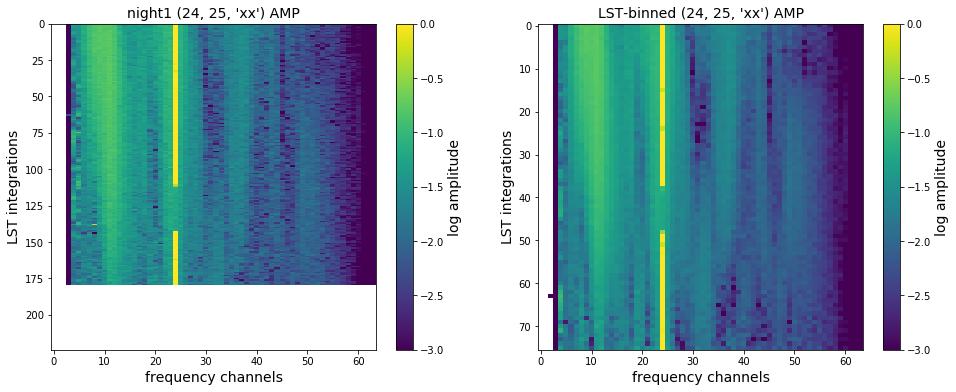

In [17]:
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
plt.sca(ax)
uvt.plot.waterfall(data1[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
uvt.plot.waterfall(data_avg[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

# run directly on the data files, write binned data to file

In [15]:
# get data files
data_files = [sorted(glob.glob(DATA_PATH+'/zen.2458042.4*')),
              sorted(glob.glob(DATA_PATH+'/zen.2458043.4*')),
              sorted(glob.glob(DATA_PATH+'/zen.2458044.4*'))]

In [16]:
rm -r zen.xx.*

rm: zen.xx.*: No such file or directory


In [17]:
# run vanilla lstbin
hc.lstbin.lst_bin_files(data_files, outdir='./', ntimes_per_file=250, align=False)


starting LST file 1 / 1: 2018-01-26 17:32:55.555032
----------------------------------------
saving ./zen.xx.LST.0.18492.uv
saving ./zen.xx.STD.0.18492.uv
saving ./zen.xx.NUM.0.18492.uv


In [18]:
# load written file
data1, flags1 = hc.abscal.UVData2AbsCalDict(data_files[0])

data2, flags2 = hc.abscal.UVData2AbsCalDict(sorted(glob.glob("zen.xx.LST.*.uv")), return_wgts=False)

antenna_diameters is not set. Using known values for HERA.


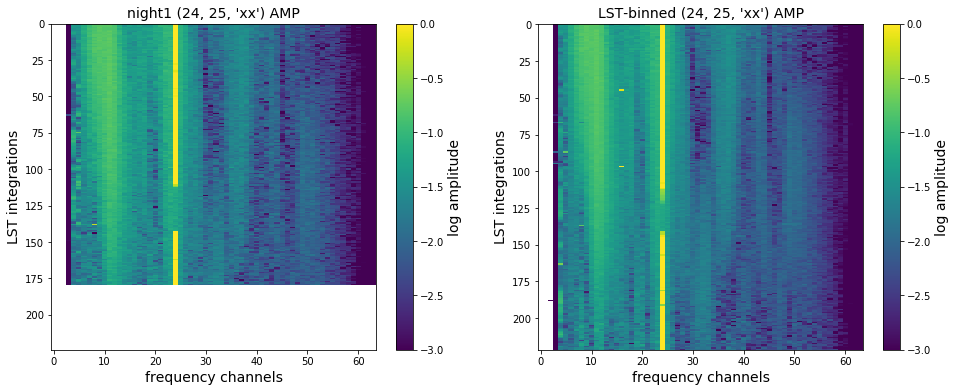

In [19]:
# plot results
key = (24, 25, 'xx')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
plt.sca(ax)
uvt.plot.waterfall(data1[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('night1 {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)
ax.set_ylim(224, 0)

ax = axes[1]
plt.sca(ax)
data2[(24,25,'xx')][flags2[(24,25,'xx')]] *= np.nan
uvt.plot.waterfall(data2[(24, 25, 'xx')], mode='log', mx=0, drng=3)
cbar = plt.colorbar()
cbar.set_label('log amplitude', fontsize=14)
ax.set_title('LST-binned {} AMP'.format(key), fontsize=14)
ax.set_xlabel('frequency channels', fontsize=14)
ax.set_ylabel('LST integrations', fontsize=14)

In [20]:
rm -r ./zen.xx.*

By eye, we get the same results as our intial plot with no LST align.